# A Neural Algorithm of Artistic Style
> Paper Implementation by Amol Budhiraja (@amolbudhiraja)

Paper: https://arxiv.org/abs/1508.06576



# Installing Libraries

In [1]:
# PyTorch Libraries - Model Architecture, Gradient Descent, Loss Functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Torchvision Libraries - VGG19 Model and Tensor Transforms
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

# PIL and Matplotlib Libraries - Image and Graph Display
from PIL import Image
import matplotlib.pyplot as plt

# TQDM - Training Loop Progress Bar
import tqdm

If available, GPUs can be used to significantly improve speed and performance.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# Loading and Transforming Images

The first step is to load the content and style images and resizing them to the same size. Additionally, to support pytorch operations, we need to convert the images to Tensors and floating point representations.

In [3]:
IMSIZE = 512
def load_img(image_name, target_size=IMSIZE):
  """Loads the image in image_name and resizes it to target_size.
  Uses a center crop to enforce the same size and converts the
  image to a Tensor in floating point representation. """
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(target_size),
      transforms.CenterCrop(target_size),
  ])
  img = Image.open(image_name).convert("RGB")
  resized_img = transform(img).unsqueeze(0)
  resized_img = resized_img.float()
  return resized_img.to(device)

style_img = load_img("./data/texture_image.jpeg")
content_img = load_img("./data/lebronjames.jpeg")

assert style_img.size() == content_img.size()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Let's see what our images look like after transforming them.

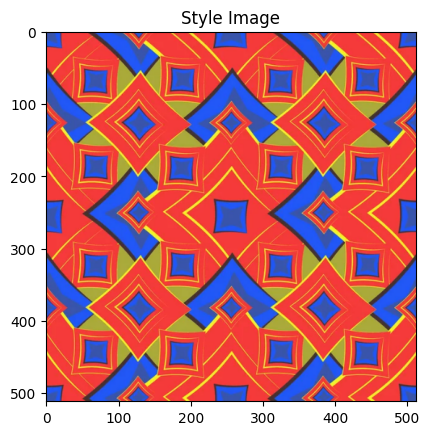

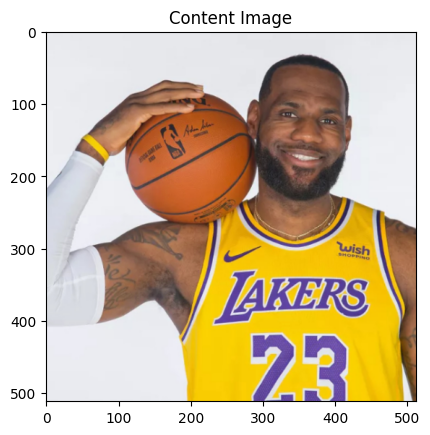

In [4]:
def imshow(img, title=None):
  """Display the given image img with title."""
  cloned_img = img.cpu().clone().squeeze(0)
  convert_to_pil = transforms.ToPILImage()
  cloned_img = convert_to_pil(cloned_img)
  plt.imshow(cloned_img)
  if title: plt.title(title)
  plt.pause(0.005)

plt.figure()
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

# Loss Functions

Now, lets define our loss functions. While it may be conventional to create custom loss functions to calculate loss in pytorch systems, I decided to create them as modules instead given that each content layer will receive its own Content Loss layer and each style layer will receive its own Style Loss layer. Then, I can calculate the loss per layer and sum them together in a single pass through the selected layers from the model instead of having multiple loss functions throughout the model.

### Content Loss

The content loss will be calculated using the following form: $L_{content}(\vec{p}, \vec{x}, \vec{l})=\frac{1}{2}\sum_{i,j}{(F^{l}_{ij}-P^{l}_{ij})^{2}}$. As a reminder this will be calculated at every layer in the `content_layers` array.

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target_img):
        super(ContentLoss, self).__init__()
        self.target_img = target_img.detach()

    def forward(self, output_img):
        """Calculate the Content Loss between output_img and target_img.
        Essentially the content loss the the MSE between the output_img and
        target_img. """
        self.loss = F.mse_loss(output_img, self.target_img)
        return output_img

### Style Loss

Based on the approach described in the paper, we will be calculating the style loss using the Gram Matrix.

Specifically, we will compute a Gram Matrix: $G^{l} \in \mathbb{R}^{N_l \times N_l}$ where $G^{l}_{ij}$ is the inner product between the vectorized feature map i and j in layer l:

> $F^{l}_{ij} = \sum_{k}{F^{l}_{ik}F^{l}_{jk}}$.




In [6]:
def get_gram_matrix(input):
    """Return the normalized gram matrix for the given image input. The gram matrix
    represents the inner product between the image's features and a transposed
    version of itself."""
    batch_size, num_feature_maps, xdim, ydim = input.size()
    M, N = batch_size * num_feature_maps, xdim * ydim
    features = input.view(M, N)
    gram_matrix = features @ features.T
    total_num_features = M*N
    normalized_gram_matrix = gram_matrix.div(total_num_features)
    return normalized_gram_matrix

Now, we can use this gram matrix and create our Style loss function that assess the mean-squared distance between the entires of the Gram matrix of the original matrix and the image to be generated:

$L_{style}(\vec{a}, \vec{x}) = \sum_{l=0}^{L}w_{l}E_{l}$ where, $E_{l} = \frac{1}{4N^{2}_{l}M^{2}_{l}}\sum_{i,j}{(G_{ij}^{l} - A_{ij}^{l})^{2}}$

In [7]:
class StyleLoss(nn.Module):
    def __init__(self, target_img):
        super(StyleLoss, self).__init__()
        self.target_gram_matrix = get_gram_matrix(target_img).detach()

    def forward(self, output_img):
      """Calculate the Style Loss between output_img and target_img.
        Essentially the Style loss the the MSE between the gram matrix of the
        output_img and the gram matrix of the target_img. """
      output_gram_matrix = get_gram_matrix(output_img)
      self.loss = F.mse_loss(output_gram_matrix, self.target_gram_matrix)
      return output_img

# Creating the Model

We also need to preprocess our images to be passed into the layers extracted from the VGG-19 model. Besides the transformations done at loading time, the only additional transform that we would have to do would be to normalize the images.

In [8]:
class VGG19Preprocessor(nn.Module):
    def __init__(self):
        super(VGG19Preprocessor, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)

    def forward(self, img):
        """Preprocess the given image img by normalizing it."""
        return (img - self.mean) / self.std

Now lets put all these elements together to create our model.

In [9]:
def get_model_and_losses(style_img, content_img):
    """Return the model, style_img, and content_img after parsing the
    content and style layers. It also parses out pointers to the content
    and style loss layers to simplify the process of collecting the losses."""
    VGG19Model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    preprocessor_layer = VGG19Preprocessor()

    content_loss_layers, style_loss_layers = [], []

    model = nn.Sequential(preprocessor_layer)

    layer_idx, name = 0, None
    for layer in VGG19Model.children():
        if isinstance(layer, nn.Conv2d):
            layer_idx += 1
            name = f"conv_{layer_idx}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{layer_idx}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{layer_idx}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{layer_idx}"

        if name: model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss_layer = ContentLoss(target)
            model.add_module(f"content_loss_{layer_idx}", content_loss_layer)
            content_loss_layers.append(content_loss_layer)

        if name in style_layers:
            target = model(style_img).detach()
            style_loss_layer = StyleLoss(target)
            model.add_module(f"style_loss_{layer_idx}", style_loss_layer)
            style_loss_layers.append(style_loss_layer)

    # Removing layers from the VGG19 Model that are not used in the
    # content/style loss calculation.
    for i in reversed(range(len(model))):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_loss_layers, content_loss_layers

# Preparing the Model

We can combine this model and loss functions together.

Lets also define a combined squared error loss function between the two feature representations:

> $L_{total}(\vec{p}, \vec{a}, \vec{x}) = \alpha L_{content}(\vec{p}, \vec{x}) + \beta L_{content}(\vec{a}, \vec{x})$
>
> where $\alpha, \beta$ are weighing factors for the content and style reconstruction respectively.

For the optimizer, let's use the L-BFGS optimizer. The LGFGS optimizer is a memory-efficient version of the BFGS algorithm. The BFGS algorithms is a type of quasi-Newton method that requires calculating the Hessian matrix of the function, which can be computationally expensive. L-BFGS maintains a limited memory of past updates to approximate the Hessian matrix - instead of storing it directly.

In [10]:
def transfer_style(content_img, style_img, num_steps=100,
                       style_weight=100000, content_weight=1):
    """Transfers the style from style_img to content_img. Uses num_steps
    gradient steps and uses style_weight and content_weight in the loss value
    calculation."""
    model, style_loss_layers, content_loss_layers = get_model_and_losses(style_img, content_img)

    input_img = content_img.clone()
    input_img.requires_grad_(True)

    model.eval()
    model.requires_grad_(False)

    optimizer = optim.LBFGS([input_img])

    for i in tqdm.tqdm(range(num_steps), desc="Running Style Transfer"):
        def closure():
          """The LBFGS optimizer commonly uses a closure function design
          pattern."""
          with torch.no_grad():
              input_img.clamp_(0, 1)

          optimizer.zero_grad()
          model(input_img)

          style_score = 0
          content_score = 0

          for sl in style_loss_layers:
              style_score += sl.loss
          for cl in content_loss_layers:
              content_score += cl.loss

          loss = (style_score * style_weight) + (content_score * content_weight)
          loss.backward()
          return style_score + content_score
        optimizer.step(closure)

    with torch.no_grad():
      input_img.clamp_(0, 1)
    return input_img

# Testing Model

Finally, let's try out the function! Provide the content image and the style image as inputs to test out the algorithm.

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 188MB/s]
Running Style Transfer: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


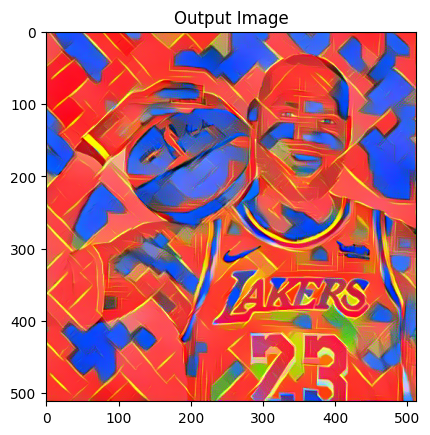

In [11]:
output = transfer_style(content_img, style_img)

plt.figure()
imshow(output, title='Output Image')